In [4]:
import platform
import pandas as pd
import sklearn
import os
import numpy as np

In [5]:
data_folder= 'nba20-21 data'
df=pd.DataFrame()
for file_ in os.listdir(data_folder):
    temp=pd.read_csv(data_folder+'/'+file_,header=None,skiprows=1)
    df=pd.concat([df,temp],ignore_index=True)

df.columns=['time', 'visitors', 'visitor_pts', 'home', 'home_pts', 'box_score', '6', 'attendees', 'notes', 'month']
df.to_csv('single_nba_file.csv',index=False)

In [6]:
df= df.drop(['time', 'box_score', '6', 'attendees', 'notes'], axis=1)

In [18]:
from sklearn.metrics import f1_score, make_scorer, classification_report

scorer= make_scorer(f1_score, pos_label= None, average= 'weighted')

## Plotting column that tells whether the home team won corres to each match

In [8]:
df['home_wins']= df['visitor_pts'] < df['home_pts']
y_true= df['home_wins'].values
df

,visitors,visitor_pts,home,home_pts,month,home_wins
0,Golden State Warriors,99.0,Brooklyn Nets,125.0,December,True
1,Los Angeles Clippers,116.0,Los Angeles Lakers,109.0,December,False
2,Charlotte Hornets,114.0,Cleveland Cavaliers,121.0,December,True
3,New York Knicks,107.0,Indiana Pacers,121.0,December,True
4,Miami Heat,107.0,Orlando Magic,113.0,December,True
...,...,...,...,...,...,...
1153,Memphis Grizzlies,133.0,Houston Rockets,84.0,February,False
1154,Golden State Warriors,91.0,Los Angeles Lakers,117.0,February,True
1155,Atlanta Hawks,99.0,Miami Heat,109.0,February,True
1156,Phoenix Suns,118.0,Minnesota Timberwolves,99.0,February,False


## Calculating the Home-win Percentage

In [9]:
n_games= df['home_wins'].count()
n_homewins= df['home_wins'].sum() #counts only those values that are true
homewin_percent= n_homewins/ n_games

In [10]:
n_games, n_homewins, homewin_percent

(1158, 608, 0.5250431778929189)

In [50]:
y_pred= [1]*len(y_true) #predicting 1 or True for the entire dataset
len(y_pred)

1158

## Finding the baseline score

In [12]:
score= f1_score(y_true, y_pred, pos_label= None, average= 'weighted')

In [13]:
score

0.36152463438153415

## Plotting a pie chart of total no. of home wins in each month

In [35]:
month_list= ['December', 'January', 'February', 'March', 'April', 'May']
month_wise_hometeam_wins= []
for month in month_list:
    month_wise_hometeam_wins.append(df[df['month']==month]['home_wins'].sum())

In [38]:
month_wise_hometeam_wins

[33, 118, 120, 107, 131, 99]

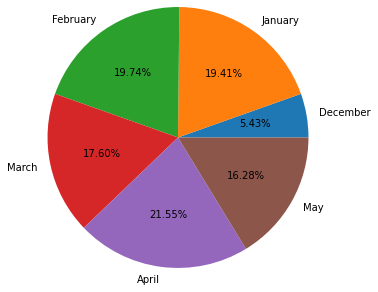

In [45]:
from matplotlib import pyplot as plt
plt.axis('equal')
plt.pie(month_wise_hometeam_wins, labels= month_list, radius=1.5, autopct= '%0.2f%%')
plt.show()

## Feature Engineering

In [14]:
df['home_last_win']= False
df['visitor_last_win']= False

### Now we compute the actual value for these and find whether the home and visitor teams win their last game or not

In [15]:
from collections import defaultdict
won_last= defaultdict(bool)

for index, row in df.iterrows():
    home_team= row['home']
    visitor_team= row['visitors']
    row['home_last_win']= won_last[home_team]
    row['visitor_last_win']= won_last[visitor_team]
    #print(row)
    df.iloc[index]= row
    
    #Set current win
    won_last[home_team]= row['home_wins']
    won_last[visitor_team]= not row['home_wins']

In [47]:
#df

## Create a dataset with just the necessary information

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

x_prev_wins= df[['home_last_win', 'visitor_last_win']].values
clf= DecisionTreeClassifier(random_state= 14)
scores= cross_val_score(clf, x_prev_wins, y_true, scoring= scorer)

In [48]:
print(np.mean(scores)) #new, engineered score

0.5526574256395705


## Win Streak Analysis

In [22]:
df['home_win_streak']= 0
df['visitor_win_streak']= 0

### Did the home and visitor teams win their last game?
win_streak= defaultdict(int)

for index, row in df.iterrows():
    home_team= row['home']
    visitor_team= row['visitors']
    row['home_win_streak']= win_streak[home_team]
    row['visitor_win_streak']= win_streak[visitor_team]
    df.iloc[index]= row
    
    #Set current win
    if row['home_wins']:
        win_streak[home_team]+= 1
        win_streak[visitor_team]= 0
    else:
        win_streak[home_team]= 0
        win_streak[visitor_team]+= 1

In [49]:
#df

In [24]:
x_win_streak= df[['home_last_win', 'visitor_last_win', 'home_win_streak', 'visitor_win_streak']].values
clf= DecisionTreeClassifier(random_state= 14)
scores2= cross_val_score(clf, x_win_streak, y_true, scoring= scorer)

In [25]:
np.mean(scores2) 

0.5358970126494802